## Import Libraries

In [1]:
import os
import random
from glob import glob
from PIL import Image
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### Function : prepare train test

In [38]:
def train_test_prepare(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
    
    train_datagen = ImageDataGenerator(
                        rescale= 1./255,
                        rotation_range=40,
                        width_shift_range=0.5,
                        height_shift_range=0.5,
                        shear_range=0.5,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')
    train_datagen.fit(X_train)
    
    test_datagen = ImageDataGenerator(
                        rescale= 1./255)
    test_datagen.fit(X_test)
    
    return X_train, X_test, Y_train, Y_test

### Function : build model

In [3]:
def model_build():

    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3,3), input_shape=(28, 28, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(7, activation='softmax')
    ])
    
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
            metrics=['accuracy'])
    
    print(model.summary())
    return model

In [4]:
def model_build_1():

    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3,3), input_shape=(28, 28, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(7, activation='softmax')
    ])
    
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
            metrics=['accuracy'])
    
    print(model.summary())
    return model

### Function : train model

In [5]:
def model_train(model, X_train, Y_train, EPOCHS=25):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0, verbose=1, mode="auto")
        
    history = model.fit(
                    X_train,
                    Y_train,
                    epochs= EPOCHS,
                    batch_size = 64,
                    callbacks= [reduce_lr],
                    validation_split=0.1)
    return history

### Function : Plot 

In [6]:
def plot_acc(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Function : test model

In [7]:
def model_test(model, X_test, Y_test):
    true_label = np.array(Y_test)
    predicted_label = model.predict(X_test)
    predicted_label = np.array(list(map(lambda x: np.argmax(x), predicted_label)))
    
    sample_images = X_test[:20]
    plt.figure(figsize=(22, 12))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title('true : ' + dict_label[true_label[i]] + ' - predicted : ' + dict_label[predicted_label[i]])
        plt.axis("off")
    plt.show()
    

### Function : Confusion Matrix

In [8]:
def matrix_conf(model, X_test, Y_test):
    
    accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
    print('Accuracy : {:.2f}%'.format(accuracy * 100))
    
    true_label = np.array(Y_test)
    predicted_label = model.predict(X_test)
    predicted_label = np.array(list(map(lambda x: np.argmax(x), predicted_label)))
    
    clr = classification_report(true_label, predicted_label, target_names=dict_label.values())
    print(clr)

    matrix = confusion_matrix(true_label, predicted_label)
    print (matrix)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, annot=True, fmt="d");

## Read Data

In [9]:
base_dir = os.path.join('..', 'dataset_skin')

# create dictionary for image path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir,"mnist-ham10000/", '*', '*.jpg'))}

# create dictionary for lesions
lesions_dict = {
    'nv': 'Melanocytic Nevi',   # kutil
    'mel': 'Melanoma',          # kanker
    'bkl': 'Benign Keratosis-like Lesions',  # kanker jinak
    'bcc': 'Basal Cell Carcinoma',   # keganasan sel basal
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

In [10]:
dict_label = {
        0: 'akiec',
        1: 'bcc',
        2: 'bkl',
        3: 'df',
        4: 'nv',
        5: 'mel',
        6: 'vasc'
    }

In [11]:
df = pd.read_csv(os.path.join(base_dir,"mnist-ham10000/",'HAM10000_metadata.csv'))

In [12]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [13]:
df['lesion_type'] = df['dx'].map(lesions_dict.get)
df['image_path'] = df['image_id'].map(imageid_path_dict.get)
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes

In [14]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,image_path,lesion_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2


In [15]:
df.drop(df[df['image_id'] == 'ISIC_0030381'].index, inplace=True)

In [16]:
df['lesion_type_idx'].nunique()

7

In [17]:
tqdm.pandas()

df['image_pixel'] = df['image_path'].progress_apply(lambda x: np.asarray(Image.open(x).resize((28,28))))

100%|████████████████████████████████████████████████████████████████████████████| 10014/10014 [14:40<00:00, 11.37it/s]


In [18]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,image_path,lesion_type_idx,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,..\dataset_skin\mnist-ham10000\HAM10000_images...,2,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


## Data Exploratory

In [19]:
df['lesion_type'].value_counts()

Melanocytic Nevi                 6704
Melanoma                         1113
Benign Keratosis-like Lesions    1099
Basal Cell Carcinoma              514
Actinic Keratoses                 327
Vascular Lesions                  142
Dermatofibroma                    115
Name: lesion_type, dtype: int64

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lesion_type', ylabel='count'>

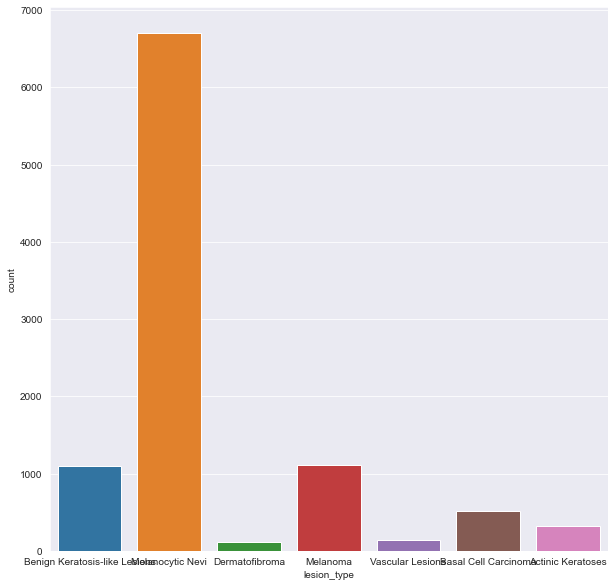

In [20]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(df['lesion_type'])

In [21]:
# Listing the index number of each column to use in df sample
for i in df.columns:
   print(df.columns.get_loc(i), ':', i)

0 : lesion_id
1 : image_id
2 : dx
3 : dx_type
4 : age
5 : sex
6 : localization
7 : lesion_type
8 : image_path
9 : lesion_type_idx
10 : image_pixel


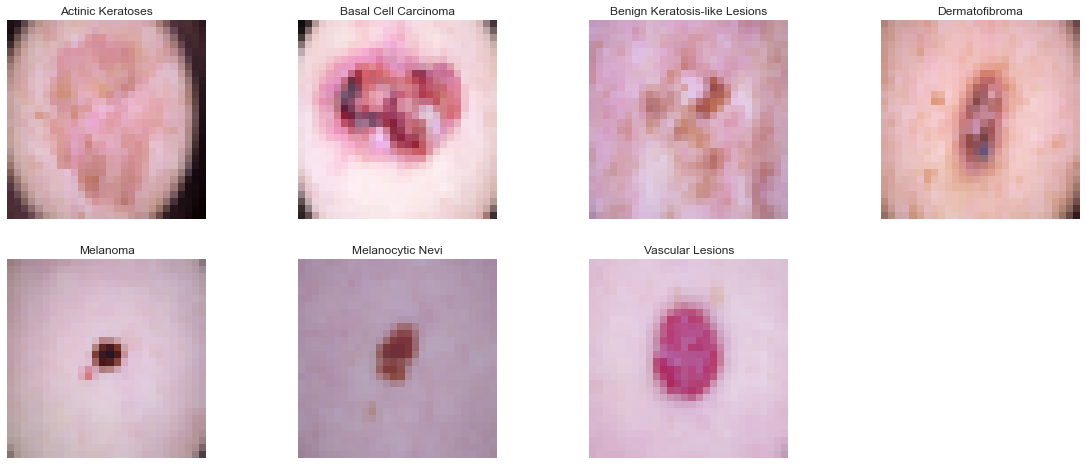

In [22]:
# create sample data to display
df_sample = df.groupby('dx').apply(lambda df: df.iloc[:1, [7, 10]])

# display sample data
plt.figure(figsize=(20,30))
for i in range(len(df_sample)):
    plt.subplot(7, 4, i + 1)
    plt.imshow(df_sample['image_pixel'][i])
    plt.title(df_sample['lesion_type'][i])
    plt.axis("off")
plt.show()

In [23]:
df = df.sort_values('lesion_type_idx')
df = df.reset_index()

In [24]:
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,image_path,lesion_type_idx,image_pixel
0,9804,HAM_0000501,ISIC_0031335,akiec,histo,60.0,male,face,Actinic Keratoses,..\dataset_skin\mnist-ham10000\HAM10000_images...,0,"[[[183, 129, 133], [185, 130, 131], [186, 127,..."
1,9790,HAM_0004609,ISIC_0024710,akiec,histo,75.0,male,back,Actinic Keratoses,..\dataset_skin\mnist-ham10000\HAM10000_images...,0,"[[[214, 197, 211], [216, 197, 213], [218, 201,..."
2,9791,HAM_0004780,ISIC_0029315,akiec,histo,75.0,male,lower extremity,Actinic Keratoses,..\dataset_skin\mnist-ham10000\HAM10000_images...,0,"[[[178, 153, 154], [186, 166, 172], [190, 172,..."
3,9792,HAM_0003157,ISIC_0029811,akiec,histo,65.0,male,upper extremity,Actinic Keratoses,..\dataset_skin\mnist-ham10000\HAM10000_images...,0,"[[[200, 152, 165], [204, 161, 179], [206, 163,..."
4,9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,Actinic Keratoses,..\dataset_skin\mnist-ham10000\HAM10000_images...,0,"[[[130, 93, 93], [182, 145, 144], [203, 166, 1..."


In [25]:
df.shape

(10014, 12)

## Define X and Y

In [26]:
X = df['image_pixel'].to_numpy()
X = np.stack(X, axis=0)
print(X.shape)

(10014, 28, 28, 3)


In [27]:
Y = df['lesion_type_idx'].to_numpy()
Y = np.expand_dims(Y, axis=1)
print(Y.shape)

(10014, 1)


In [28]:
df.sort_values('lesion_type_idx')['lesion_type_idx'].value_counts()

4    6704
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: lesion_type_idx, dtype: int64

In [29]:
reshaped_X = X.reshape(X.shape[0],-1)
print(X.shape)

(10014, 28, 28, 3)


In [30]:
# oversample metode Random Over Sample

oversample = RandomOverSampler(random_state=42)
reshaped_X, Y  = oversample.fit_resample(reshaped_X,Y)
os_X = np.array(reshaped_X).reshape(-1,28,28,3)

print('Shape of Data :', reshaped_X.shape)

Shape of Data : (46928, 2352)


In [31]:
# # oversample metode SMOTE

# oversample = SMOTE(random_state=2)
# reshaped_X, Y  = oversample.fit_resample(reshaped_X,Y)
# os_X = np.array(reshaped_X).reshape(-1,28,28,3)

# print('Shape of Data :', os_X.shape)

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


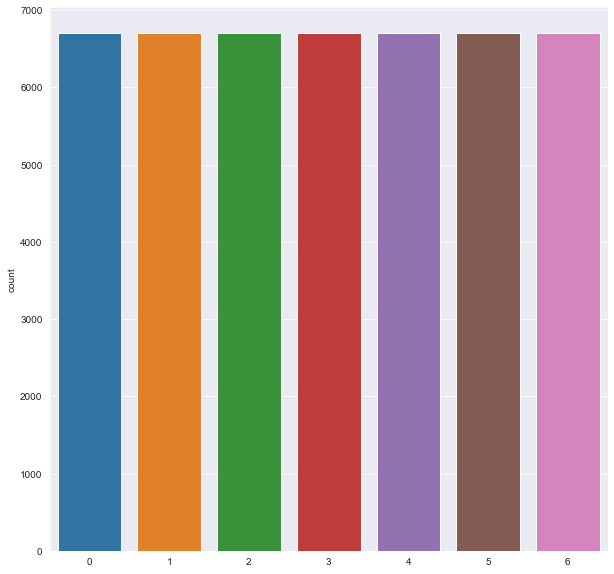

In [32]:
plt.figure(figsize = (10,10))
ax = sns.countplot(Y, x="labels")


In [39]:
X_train, X_test, Y_train, Y_test = train_test_prepare(os_X, Y)

In [40]:
print('train data : ', len(X_train))
print('test data : ', len(X_test))

train data :  37542
test data :  9386


In [41]:
model = model_build()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

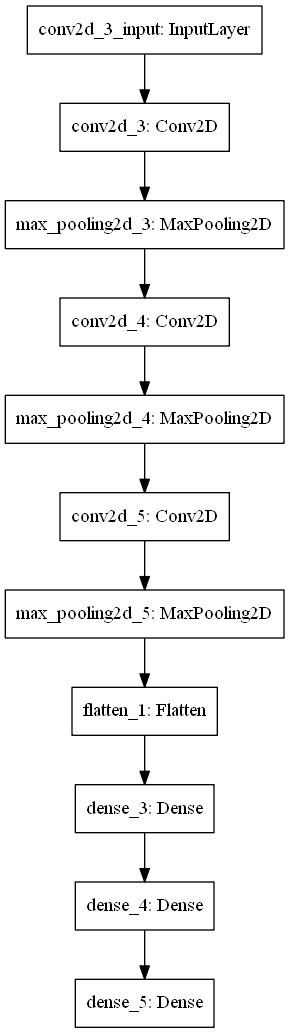

In [42]:
tf.keras.utils.plot_model(model)

In [43]:
history = model_train(model, X_train, Y_train, 50)

Epoch 1/50
528/528 [==============================] - 15s 28ms/step - loss: 1.6210 - accuracy: 0.4242 - val_loss: 1.0752 - val_accuracy: 0.5819 - lr: 0.0010
Epoch 2/50
528/528 [==============================] - 23s 43ms/step - loss: 0.9413 - accuracy: 0.6374 - val_loss: 0.8316 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 3/50
528/528 [==============================] - 21s 41ms/step - loss: 0.7205 - accuracy: 0.7231 - val_loss: 0.6525 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 4/50
528/528 [==============================] - 20s 39ms/step - loss: 0.5599 - accuracy: 0.7899 - val_loss: 0.5160 - val_accuracy: 0.8107 - lr: 0.0010
Epoch 5/50
528/528 [==============================] - 20s 38ms/step - loss: 0.4595 - accuracy: 0.8302 - val_loss: 0.3863 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 6/50
528/528 [==============================] - 20s 38ms/step - loss: 0.3668 - accuracy: 0.8660 - val_loss: 0.3493 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 7/50
528/528 [==============================] - 22s 

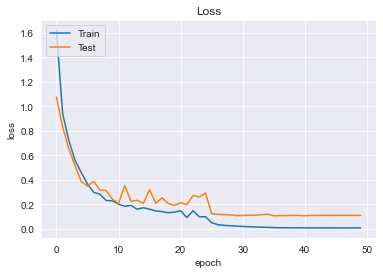

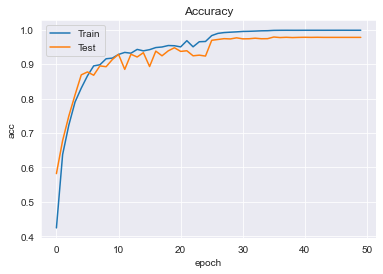

In [44]:
plot_acc(history)

Accuracy : 97.76%
              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1358
         bcc       0.99      1.00      1.00      1301
         bkl       0.94      0.99      0.97      1312
          df       1.00      1.00      1.00      1378
          nv       0.98      0.86      0.92      1334
         mel       0.93      0.99      0.96      1328
        vasc       1.00      1.00      1.00      1375

    accuracy                           0.98      9386
   macro avg       0.98      0.98      0.98      9386
weighted avg       0.98      0.98      0.98      9386

[[1358    0    0    0    0    0    0]
 [   0 1301    0    0    0    0    0]
 [   0    0 1304    0    8    0    0]
 [   0    0    0 1378    0    0    0]
 [   4    9   83    0 1144   93    1]
 [   0    0    1    0   11 1316    0]
 [   0    0    0    0    0    0 1375]]


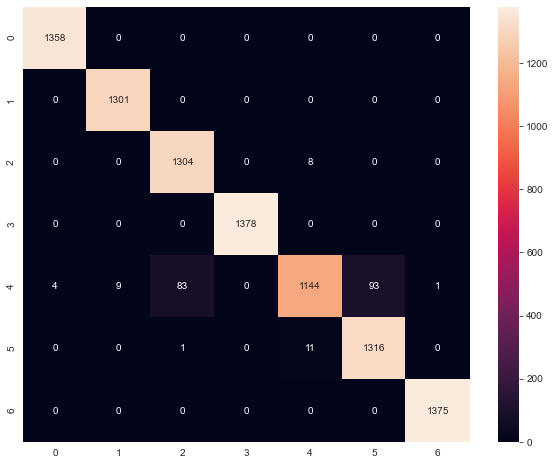

In [45]:
matrix_conf(model, X_test, Y_test)

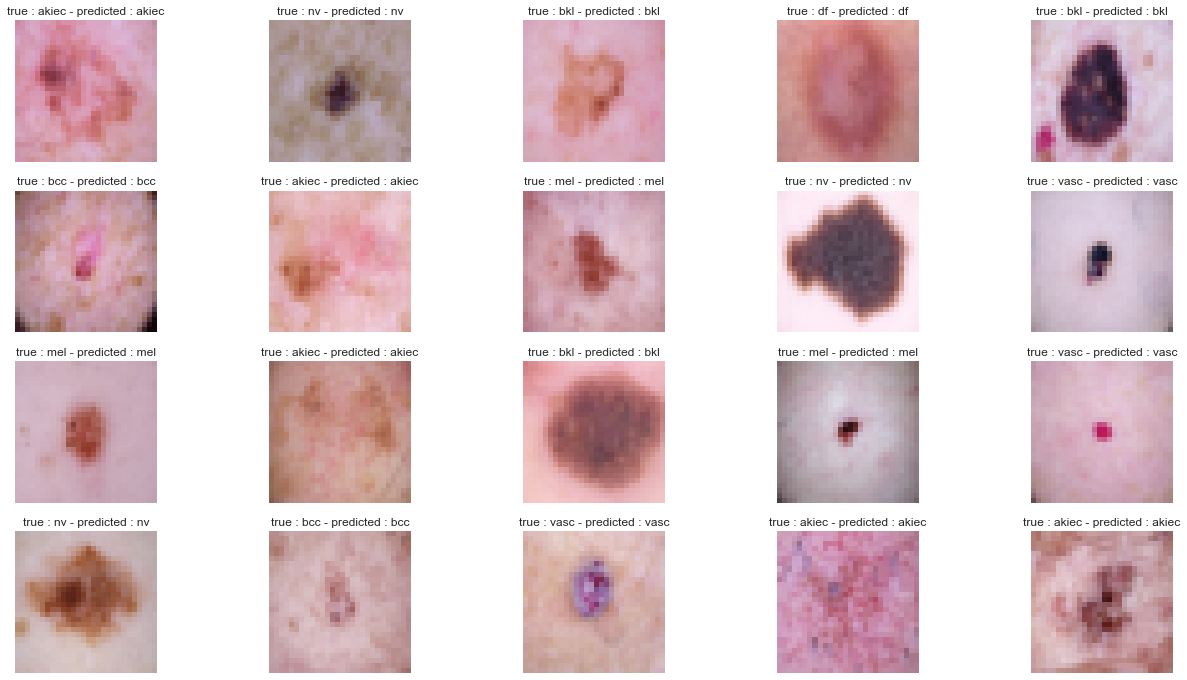

In [46]:
model_test(model, X_test, Y_test)

In [43]:
import time
saved_model_path = "./model{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [44]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2022-09-04 17:59:24.881418: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2022-09-04 17:59:24.881570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 